# TP2 - MCMC

## Estimation avancée - G3 SDIA

Dans ce TP, on s'intéresse aux méthodes d'échantillonnage dites "MCMC" (Monte Carlo par Chaînes de Markov). Le premier exercice consiste à implémenter un Metropolis-Hastings et de regarder l'influence de quelques paramètres. Le deuxième exercice mettra en oeuvre une méthode de régression bayésienne linéaire (disponible dans un deuxième notebook).

### Instructions

1. Renommer votre notebook sous la forme `tp2a_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 10 Décembre 2023, 23h59.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss

### Partie 1 - Metropolis-Hastings

Dans cet exercice, on cherche à générer des échantillons d'une loi appelée *skew-normal* (cf. [Wikipedia](https://en.wikipedia.org/wiki/Skew_normal_distribution)). C'est une loi à support sur $\mathbb{R}$ à trois paramètres : $\alpha \in \mathbb{R}$ (paramètre de skewness), $\xi \in \mathbb{R}$ (paramètre de position), et $\sigma > 0$ (paramètre d'échelle). Dans ce TP nous prendrons $\alpha = 4, \xi = 0, \sigma = 3$.

L'objectif est d'implémenter un algorithme Metropolis-Hastings (MH) avec une loi instrumentale Gaussienne $\mathcal{N}(x_n, \sigma_0^2)$ (i.e., centrée en l'état courant, de variance $\sigma_0^2$).

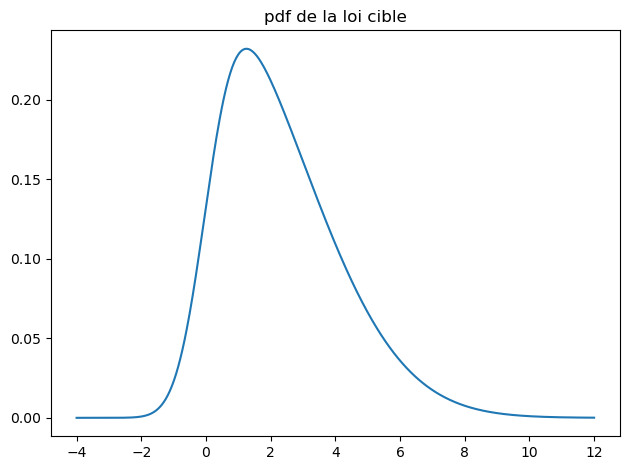

In [2]:
# pdf of the target distribution
a = 4
lc = 0
sc = 3
x = np.linspace(-4,12,500)
y = ss.skewnorm.pdf(x, a, loc=lc, scale=sc)
plt.plot(x,y)
plt.title('pdf de la loi cible')
plt.tight_layout()

**Q1.** Écrire une fonction qui implémente l'algorithme MH proposé, prenant comme arguments :
* La taille de la chaine N
* L'état initial $x_0$
* L'écart-type $\sigma_0$ de la *proposal* gaussienne
* Une graine aléatoire

Pensez à utiliser les fonctions implémentées dans `scipy.stats` pour les pdfs !

In [20]:
def metropolis_hastings(N, x0, s, seed):
    
    # Initialisation
    np.random.seed(seed)
    x = np.zeros(N)
    x[0] = x0
    i = 0
    
    while i < N-1:
        # Tirage d'un point selon la loi de proposition
        x_star = np.random.normal(x[i], s)
        
        # Calcul du ratio de Metropolis-Hastings
        r = min(1,ss.skewnorm.pdf(x_star, a, loc=lc, scale=sc)/ss.skewnorm.pdf(x[i], a, loc=lc, scale=sc)*(ss.norm.pdf(x[i], x_star, s)/ss.norm.pdf(x_star, x[i], s)))
        
        # Tirage d'un point selon une loi uniforme
        u = np.random.uniform()
        
        # Acceptation ou rejet du point
        if u < r:
            x[i+1] = x_star
        else:
            x[i+1] = x[i]
        
        i += 1
    
    return x

**Q2**. Prendre $N = 1000, x_0 = 1$. Afficher les *traceplots* (échantillons en fonction de $n$) de la chaine pour des valeurs différentes de $\sigma$ : $0.1, 2, 40$.

Pour chacun des cas, comparer la pdf de la loi cible à une estimation par noyaux de la densité ou un histogramme. Commenter.

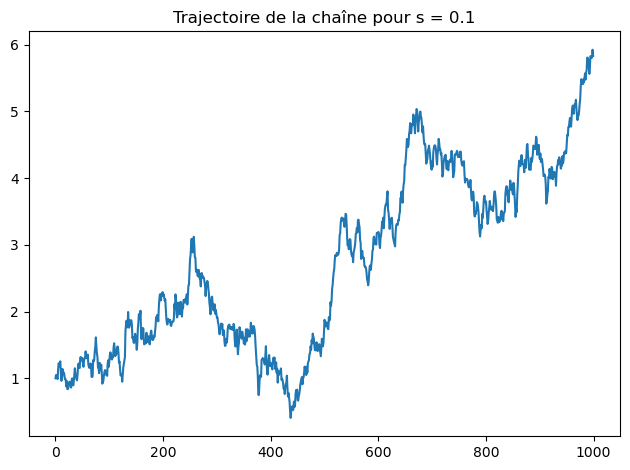

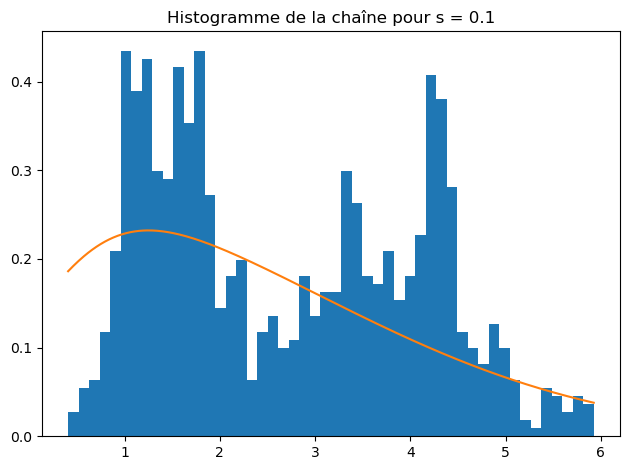

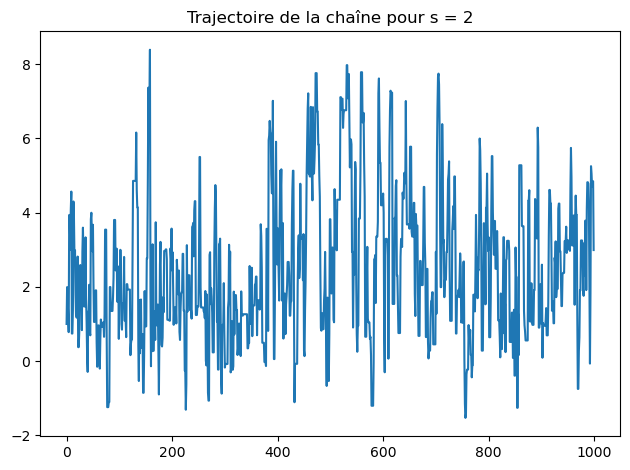

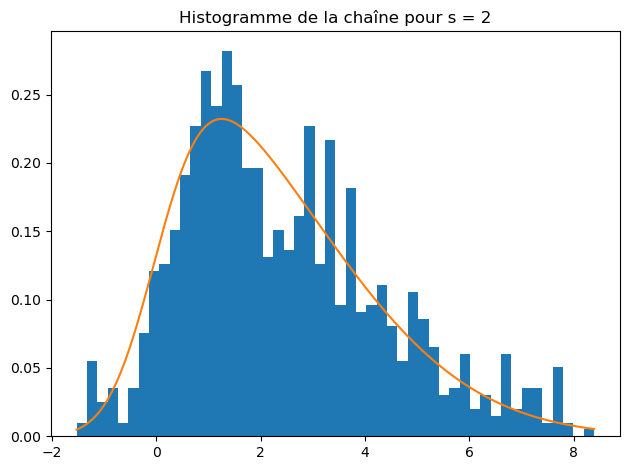

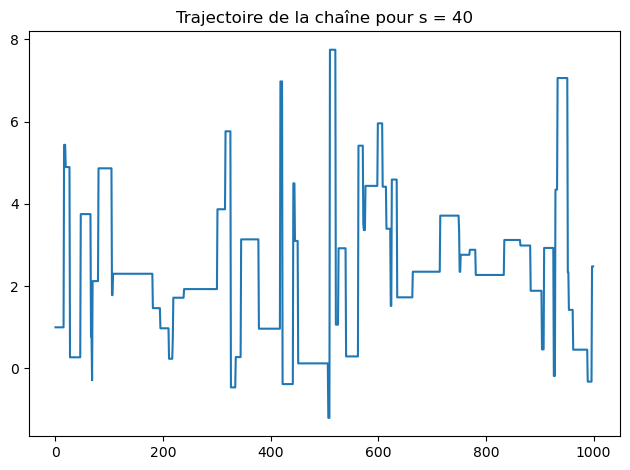

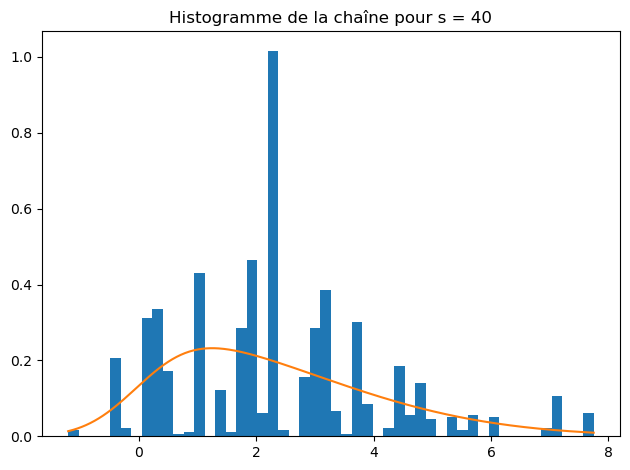

In [28]:
N = 1000
x0 = 1
s_tab = [0.1, 2, 40]
seed = 42

for s in s_tab:
    x = metropolis_hastings(N, x0, s, seed)
    plt.figure()
    plt.plot(x)
    plt.title('Trajectoire de la chaîne pour s = {}'.format(s))
    #add the pdf of the target distribution on the same plot
    
    plt.tight_layout()
    plt.show()
    z= np.linspace(np.min(x),np.max(x),500)
    plt.hist(x, bins=50, density=True)
    y = ss.skewnorm.pdf(z, a, loc=lc, scale=sc)
    plt.plot(z,y)
    plt.title('Histogramme de la chaîne pour s = {}'.format(s))
    plt.tight_layout()
    plt.show()
    


Pour $s=0.1$, on ne colle pas bien à la densité cible car la variance de la loi instrumentale est trop petite, on fait donc des petits pas et on ne couvre pas bien l'espace. Pour $s=2$, on a une bonne estimation de la densité cible, on couvre bien l'espace. Pour $s=40$, on a une variance trop grande, on essaye donc de faire des grands pas mais la proba d'acceptation est faible, on reste longtemps au meme endroit, donc on ne couvre pas bien l'espace.

**Q3.** Prendre $N = 1000, s = 2$. Afficher les *traceplots* pour $x_0$ valant 0 et 50.

Pour chacun des cas, comparer la pdf de la loi cible à une estimation par noyaux de la densité ou un histogramme. Commenter.

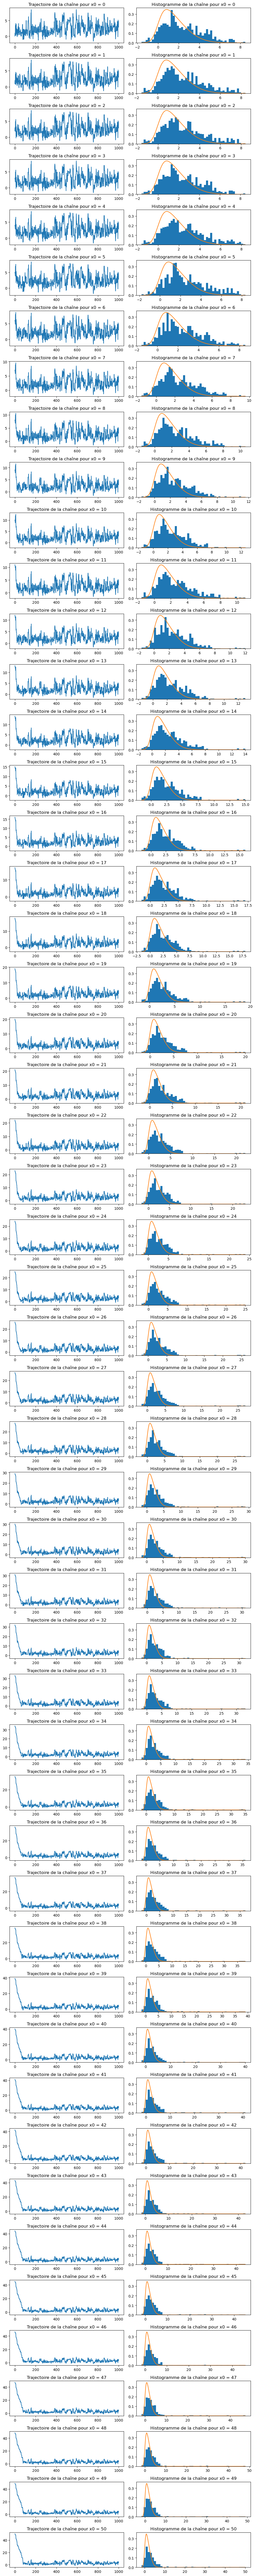

In [22]:
N = 1000
s = 2
x0_tab = [0, 50]
seed = 42
#draw 51 pair of plot in a subplot
fig, axs = plt.subplots(51,2, figsize=(10, 100))
for x0 in range(x0_tab[0], x0_tab[1]+1):
        x = metropolis_hastings(N, x0, s, seed)
        axs[x0, 0].plot(x)
        axs[x0, 0].set_title('Trajectoire de la chaîne pour x0 = {}'.format(x0))
        z= np.linspace(np.min(x),np.max(x),500)
        axs[x0, 1].hist(x, bins=50, density=True)
        y = ss.skewnorm.pdf(z, a, loc=lc, scale=s)
        axs[x0, 1].plot(z,y)
        axs[x0, 1].set_title('Histogramme de la chaîne pour x0 = {}'.format(x0))
plt.tight_layout()


plt.show()



On peut voir que globalement, on a une bonne estimation de la densité cible, on couvre bien l'espace car on a repris s=2.
On remarque que pour chaque chaine, la fin de la chaine semblent être les mêmes. Ce qu'il se  passe est que en commencant loin, les chaines vont mettre quelques itérations à converger vers le centre la densité cible, mais une fois qu'elles y sont, elles vont rester dans la même zone et adopter un comportement presque identique.
Si on réalisait un rodage, on aurait des chaines presque entièrement identiques car nous n'aurions plus cette période de retour vers le centre de la densité cible.

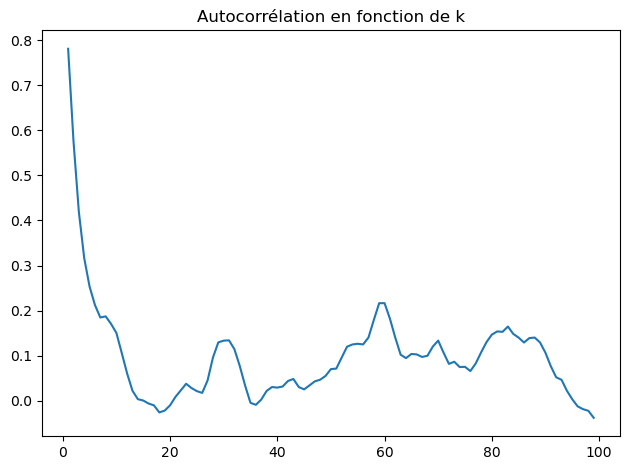

In [32]:
def get_lag_correlation(x, k):
    # compute the lag-k autocorrelation of x
    # x: array of shape (N,)
    # k: int
    N = len(x)
    x1 = x[:N-k]
    x2 = x[k:]
    return np.corrcoef(x1, x2)[0,1]
y=[]
K=[]
for k in range(1,100):
    x= metropolis_hastings(1000, 0, 2, 42)
    y.append( get_lag_correlation(x, k))
    K.append(k)
plt.plot(K,y)
plt.title('Autocorrélation en fonction de k')
plt.tight_layout()
plt.show()

Nous pouvons voir que la correlation tend vers 0 avec le lag comme on s'y attendait.